In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dl-car-classification/train.zip
/kaggle/input/sf-dl-car-classification/sample-submission.csv
/kaggle/input/sf-dl-car-classification/test.zip
/kaggle/input/sf-dl-car-classification/train.csv


In [ ]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-da7eqmlx
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-da7eqmlx
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=21b776debcd462708b9d878d14d957be5773d8f05d5e5c7952a5777f6638fbf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-f69c166n/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-ltytk28u
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-ltytk28u
     |████████████████████████████████| 50 kB 362 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18421 sha256=5cb0d2f35612f6c35f0981e5aab4022a9a9588a72d740a858028543ba0b8c96c
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5hifo3j/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras import backend as K

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

import efficientnet.keras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score


import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


'''функция графика истории обучения'''


def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
           

'''функция, выводящая все уникальные значения и их количество'''
    
    
def cat_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    sns.catplot(x=column, kind="count", palette="Blues", data=df)
    
    
print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.
    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # References
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

RANDOM_SEED = 42

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/" # рабочая директория

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['__notebook__.ipynb', 'train', 'test_upload']


Пример картинок (random sample)


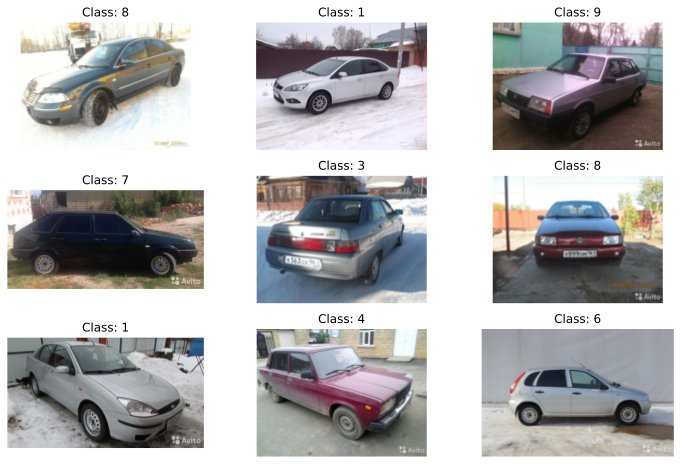

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

# АУГМЕНТАЦИЯ ДАННЫХ

In [ ]:
transform = A.Compose([
                       A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.5),
                       A.RandomRotate90(p=0.5),
                       A.Blur(p=0.5),
                       A.ChannelDropout(p=0.5),
                       A.ChannelShuffle(p=0.5),
                       A.HueSaturationValue(p=0.5),
                       A.Downscale(scale_min = 0.75, scale_max = 0.99),
                       A.ISONoise(color_shift=(0.01,0.3), intensity=(0.1,0.5),p=0.5),
                       A.MotionBlur(p=0.5),
                       A.OpticalDistortion(p=0.5)
])

In [ ]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=transform,
        preprocess_input=None,
        validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Строим модель
 
## Загружаем предобученную сеть 

In [ ]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape = input_shape)

71892992/71892840 [==============================] - 1s 0us/step


In [ ]:
print(len(base_model.layers))

467


In [ ]:
base_model.trainable = False

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add (L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,136,418
Trainable params: 462,090
Non-trainable params: 17,674,328
______________________________________

In [ ]:
print(len(model.layers))

6


# Fit

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:

callback_clr = clr = CyclicLR(base_lr=0.00001, max_lr=0.001,
                                step_size=2000., mode='triangular')

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

callback_checkpoint = ModelCheckpoint('best_model.hdf5' , 
                                      monitor = 'val_accuracy' , 
                                      verbose = 1  , 
                                      mode = 'max')

callbacks_list = [callback_checkpoint,
                 callback_early_stopping,
                 callback_clr]

In [ ]:
# Обучаем:

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
827/827 [==============================] - 230s 262ms/step - loss: 2.7761 - accuracy: 0.1657 - val_loss: 1.9286 - val_accuracy: 0.3396

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 212s 257ms/step - loss: 2.0737 - accuracy: 0.2971 - val_loss: 1.6802 - val_accuracy: 0.4010

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 213s 258ms/step - loss: 1.8782 - accuracy: 0.3266 - val_loss: 1.6121 - val_accuracy: 0.4216

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 213s 257ms/step - loss: 1.7787 - accuracy: 0.3606 - val_loss: 1.5724 - val_accuracy: 0.4418

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 216s 260ms/step - loss: 1.6914 - accuracy: 0.3923 - val_loss: 1.4889 - val_accuracy: 0.4689

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==========================

In [ ]:
# Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


146/146 [==============================] - 31s 213ms/step - loss: 1.5420 - accuracy: 0.4418
Accuracy: 44.18%


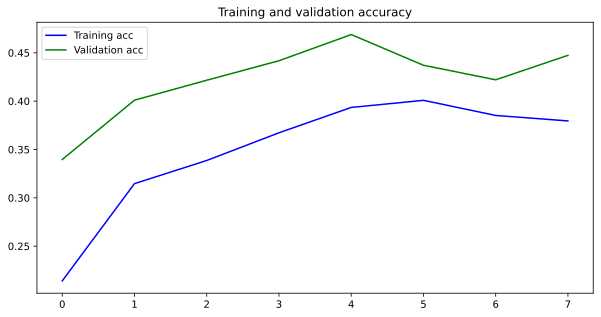

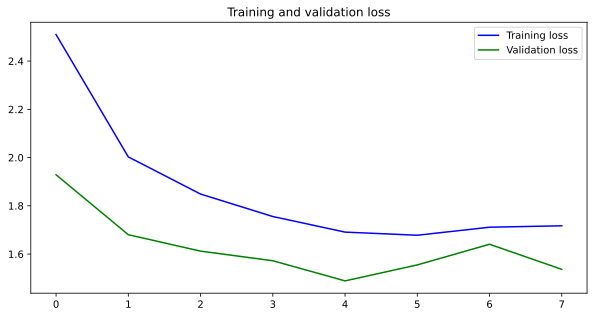

In [ ]:
plot_history(history)

step 2

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
len(base_model.trainable_variables)

208

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f64f7d08f50> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f64f74a4a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f64f7ee1290> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f64e4995fd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f64f7ee1450> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f64f7d34dd0> True


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,136,418
Trainable params: 16,604,838
Non-trainable params: 1,531,580
____________________________________

In [ ]:
# Обучаем

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 251s 287ms/step - loss: 1.6325 - accuracy: 0.4416 - val_loss: 0.7329 - val_accuracy: 0.7299

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 237s 286ms/step - loss: 0.8226 - accuracy: 0.7071 - val_loss: 0.5827 - val_accuracy: 0.7905

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 237s 286ms/step - loss: 0.7326 - accuracy: 0.7470 - val_loss: 0.7719 - val_accuracy: 0.7462

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 239s 289ms/step - loss: 0.8358 - accuracy: 0.7080 - val_loss: 0.8590 - val_accuracy: 0.7037

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 240s 290ms/step - loss: 0.8030 - accuracy: 0.7263 - val_loss: 0.5899 - val_accuracy: 0.7888

Epoch 00005: saving model to best_model.hdf5
Epoch 00005: early stopping


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 32s 222ms/step - loss: 0.5804 - accuracy: 0.7956
Accuracy: 79.56%


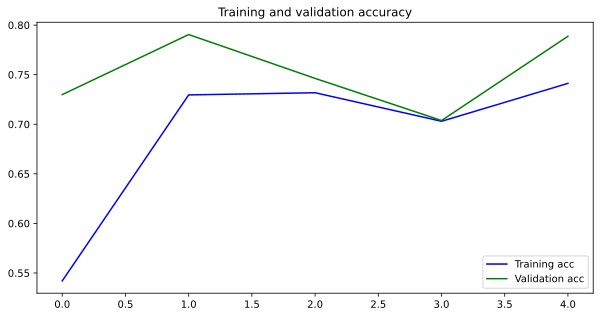

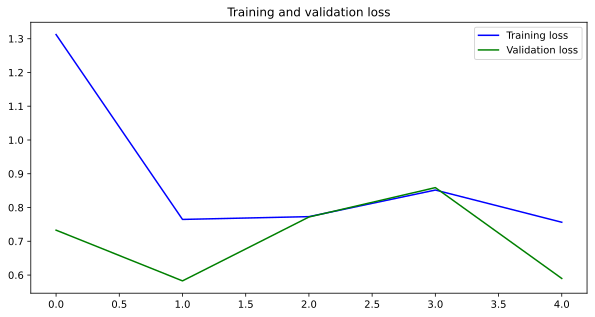

In [ ]:
plot_history(history)

step 3

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 316s 363ms/step - loss: 0.6065 - accuracy: 0.7934 - val_loss: 0.3244 - val_accuracy: 0.8806

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 293s 354ms/step - loss: 0.3577 - accuracy: 0.8760 - val_loss: 0.2820 - val_accuracy: 0.8957

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 293s 354ms/step - loss: 0.3474 - accuracy: 0.8784 - val_loss: 0.7372 - val_accuracy: 0.7600

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 291s 351ms/step - loss: 0.5415 - accuracy: 0.8150 - val_loss: 0.5478 - val_accuracy: 0.8085

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 292s 353ms/step - loss: 0.5348 - accuracy: 0.8115 - val_loss: 0.3511 - val_accuracy: 0.8789

Epoch 00005: saving model to best_model.hdf5
Epoch 00005: early stopping


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 31s 213ms/step - loss: 0.3627 - accuracy: 0.8712
Accuracy: 87.12%


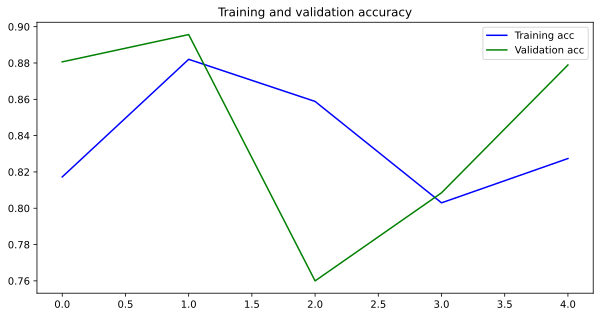

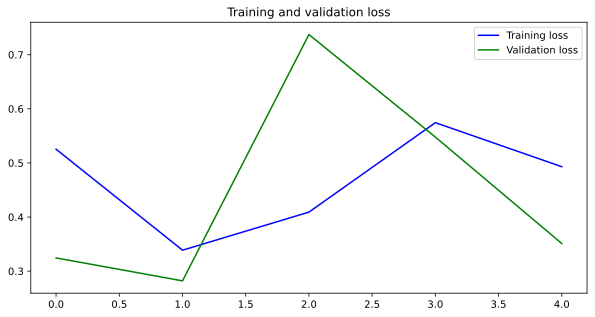

In [ ]:
plot_history(history)

step 4 large size of image

In [ ]:
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая , иначе не поместится в память на GPU
LR                   = 1e-4

IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
transform_less = A.Compose([
                       A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.5),
                       A.ChannelDropout(p=0.5),
                       A.HueSaturationValue(p=0.5),
                       A.MotionBlur(p=0.5),
])

In [ ]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=transform_less,
        preprocess_input=None,
        validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [ ]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape = input_shape)
base_model.trainable = True

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add (L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
# Обучаем

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
3308/3308 [==============================] - 1325s 396ms/step - loss: 0.5963 - accuracy: 0.8120 - val_loss: 0.4977 - val_accuracy: 0.8257

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
3308/3308 [==============================] - 1310s 396ms/step - loss: 0.4979 - accuracy: 0.8455 - val_loss: 0.3260 - val_accuracy: 0.8970

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
3308/3308 [==============================] - 1300s 393ms/step - loss: 0.5204 - accuracy: 0.8356 - val_loss: 0.1303 - val_accuracy: 0.9575

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
3308/3308 [==============================] - 1301s 393ms/step - loss: 0.4079 - accuracy: 0.8712 - val_loss: 0.1174 - val_accuracy: 0.9575

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
3308/3308 [==============================] - 1310s 396ms/step - loss: 0.3211 - accuracy: 0.9044 - val_loss: 0.1453 - val_accuracy: 0.9566

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
3308/3308 [=========

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 40s 68ms/step - loss: 0.6683 - accuracy: 0.8532
Accuracy: 85.32%


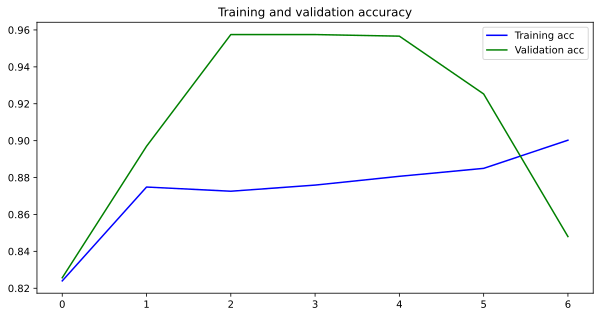

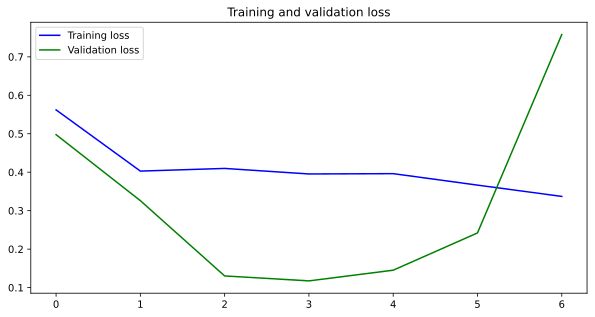

In [ ]:
plot_history(history)

Предсказываем на тестовых данных

In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 109s 64ms/step


In [ ]:
filenames_with_dir = test_sub_generator.filenames

submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


ТТА

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment=transform,
    validation_split=VAL_SPLIT,
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 342s 205ms/step


In [ ]:
test_sub_generator.reset()
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission1 = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission1['Id'] = submission1['Id'].replace('test_upload/','')
print('Save submit')

Save submit


In [ ]:
scores = model.evaluate_generator(test_sub_generator, steps = len(test_sub_generator),verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1669/1669 [==============================] - 293s 175ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH, ignore_errors=True)

In [ ]:
submission.to_csv('submission_1.csv', index=False)
submission1.to_csv('submission_TTA.csv', index=False)

Очень нестабильный результаты, если использовать CLR и оптимайзер Adam, возможно, они друг другу мешают и нужно оптимизировать модель иначе